### Cargo Librerias




## Data Science 2021 - Presentación Churnless - Mayo 2022 Rev.3



### 
---
 Presentación de :

 Leandro Scquizzato, lscquizzato@gmail.com
 
 <div>
    <img src="tipo-de-energia-electrica-scaled.jpg"/>
<div>

---

## Imports de Librerías

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
#import matplotlib as mplimport seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from scipy import stats
from statistics import mode
from sklearn import metrics
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Importamos el modelo ARIMA de statsmodels
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Seteos globales de warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
# Opción de Pandas para visualizar todas las columnas
pd.set_option('display.max_columns', None)

## Funciones

### Función para evaluar resultados

In [3]:
# Evaluation function
# ==============================================================================
def evaluation(y_true, y_pred, y_proba=[], verbose=0):
    
    if verbose == 1:
        # Print Accuracy, Recall, F1 Score, and Precision metrics.
       # print('Evaluation Metrics:')
       #print('Accuracy:   ' + str(metrics.accuracy_score(y_true, y_pred)))
        #print('Recall:     ' + str(metrics.recall_score(y_true, y_pred)))
       # print('F1 Score:   ' + str(metrics.f1_score(y_true, y_pred)))
        #print('Precision:  ' + str(metrics.precision_score(y_true, y_pred)))
        #if y_proba == []:
       #     print('ROC_AUC:    ' + str(metrics.roc_auc_score(y_true, y_pred)))
       # else:
       #     print('ROC_AUC:    ' + str(metrics.roc_auc_score(y_true, y_proba)))
        
        
        print('MAE = {}'.format(metrics.mean_absolute_error(y_true, y_pred)))
        print('RMSD = {}'.format(np.sqrt(metrics.mean_squared_error(y_true, y_pred))))
        print('MAPE = {}'.format(metrics.mean_absolute_percentage_error(y_true, y_pred)))
        
        # Print Confusion Matrix
        #print('\nConfusion Matrix:')
        #print('   TN   FP   FN   TP')
        #conf_mat = metrics.confusion_matrix(y_true, y_pred)
        #print(conf_mat.ravel())
        #print()
        #conf_mat_df = pd.DataFrame(data=conf_mat,
         #                          index=['Actual Negative: 0', 'Actual Positive: 1'],
        #                           columns=['Predict Negative: 0', 'Predict Positive: 1'])
        
        #sns.heatmap(conf_mat_df, annot=True, fmt='d', cmap='YlGnBu');
                
    #Accuracy = metrics.accuracy_score(y_true, y_pred).round(3)
    #Recall = metrics.recall_score(y_true, y_pred).round(3)
    #F1_Score = metrics.f1_score(y_true, y_pred).round(3)
    #Precision = metrics.precision_score(y_true, y_pred).round(3)
    #if y_proba == []:
     #   Roc_auc = metrics.roc_auc_score(y_true, y_pred).round(3)        
    else:
       # Roc_auc = metrics.roc_auc_score(y_true, y_proba).round(3)
        
        MAE = metrics.mean_absolute_error(y_true, y_pred).round(3)
        RMSD = np.sqrt(metrics.mean_squared_error(y_true, y_pred)).round(3)
        MAPE= metrics.mean_absolute_percentage_error(y_true, y_pred).round(3)
    
        final = []
    #final.append(Accuracy)
    #final.append(Recall)
    #final.append(F1_Score)
    #final.append(Precision)
    #final.append(Roc_auc)
        final.append(MAE)
        final.append(RMSD)
        final.append(MAPE)
    #cm = metrics.confusion_matrix(y_true, y_pred)
    #for t in cm[0]:
    #    final.append(t)
    #for t in cm[1]:
    #    final.append(t)
    
        return final

### Función Limpieza de Ouliers, devuelve un array de bool con los "no outliers"


In [4]:
# Función para remover outliers, datapd es el array de panda y columna es la columna de la que queremos retirar los outliers.
# Está medio copiado de la clase 12, con el agregado de la posibilidad de pasarle dos valores extremos, un max y un min como
# límites de descarte de datos, elimina mayores que max y menores que min.
# Devuelve array con bool de los no outliers
# Parámetros
# datapd: dataset de pandas 
# columna: columna del dataset
# hab_Q3Q1: Si es False no ejecuta lógica de Cuartiles, Si es True la ejecuta
# max: el valor máximo de la columna
# min: el valor mínimo de la columna
# El max y el min los considera tanto si hab_Q3Q1 es True como False
# ==============================================================================

def remover_outliers(datapd, columna, hab_Q3Q1=False, max=100000.0, min=0.0):
    
    if hab_Q3Q1 == True:
        q1 = datapd[columna].quantile(0.25)
        #print('q1:', q1.round(2))
        q2 = datapd[columna].quantile(0.5)
        #print('q2:', q2.round(2))
        q3 = datapd[columna].quantile(0.75)
        #print('q3:', q3.round(2))
        iqr = (q3 - q1.round(2)) * 4 #!!! OJO CAMBIADO este valor de 1.5 !!!
        up_threshold = q3 + iqr
        low_threshold = q1 - iqr
        if low_threshold < min:
            low_threshold = min
        if up_threshold > max:
            up_threshold = max
    if hab_Q3Q1 != True:
        low_threshold = min
        up_threshold = max
    
    
    #print('up_threshold:', round(up_threshold,2))
    #print('low_threshold:', round(low_threshold,2))
    outlier_mask_up = datapd[columna] > up_threshold
    outlier_mask_down = datapd[columna] < low_threshold
    outlier_mask = np.logical_or(outlier_mask_up, outlier_mask_down)
    not_outliers = np.logical_not(outlier_mask)
    #data_pd_sin_outliers = datapd[not_outliers]
    #return data_pd_sin_outliers
    return not_outliers

## Función para realizar Dick Fuller y verificar si es estacionario. Si p-value es menor que 0,5  es estacionaria

In [87]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    #Plot rolling statistics:
    plt.figure(figsize=(15,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    #perform dickey fuller test  
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['MW'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    

## Función Cálculo error cuadrático medio

In [6]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

## Lectura de Dataset

In [7]:
df = pd.read_csv("../Data/train_sample.csv")

df

,Datetime,MW
0,7/24/18 23:00,3476
1,7/24/18 22:00,3720
2,7/24/18 21:00,3766
3,7/24/18 20:00,3851
4,7/24/18 19:00,3954
...,...,...
57517,1/1/12 5:00,2279
57518,1/1/12 4:00,2313
57519,1/1/12 3:00,2364
57520,1/1/12 2:00,2465


## Busqueda de duplicados

In [8]:
df[df.Datetime.duplicated(keep=False)]

,Datetime,MW
6284,11/5/17 2:00,2064
6285,11/5/17 2:00,1044
15020,11/6/16 2:00,2350
15021,11/6/16 2:00,2198
23924,11/1/15 2:00,2164
23925,11/1/15 2:00,2257
32660,11/2/14 2:00,2518
32661,11/2/14 2:00,2562


In [9]:
#Se encuentran 4 valores duplicados. los borramos y vemos que no están
# ==============================================================================

df.drop_duplicates(subset=['Datetime'],keep="last",inplace=True)

In [10]:
df[df.Datetime.duplicated(keep=False)]

,Datetime,MW


## Conversión de string a Datetime y set como índice

In [11]:
df = df.set_index('Datetime')
df.index=df.index.map(lambda x : datetime.strptime(x,"%m/%d/%y %H:%M"))
df

,MW
Datetime,
2018-07-24 23:00:00,3476
2018-07-24 22:00:00,3720
2018-07-24 21:00:00,3766
2018-07-24 20:00:00,3851
2018-07-24 19:00:00,3954
...,...
2012-01-01 05:00:00,2279
2012-01-01 04:00:00,2313
2012-01-01 03:00:00,2364


## Ajustes varios, busqueda de nulls, verificación de orden, uso de describe para buscar valores muy locos


In [12]:
df.sort_values('Datetime', inplace=True)

In [13]:
df.isnull().sum()

MW    0
dtype: int64

## En base al describe no hay valores obviamente erroneos

In [14]:
df.describe()

,MW
count,57518.000000
mean,3104.043708
std,599.622761
min,907.000000
25%,2687.000000
50%,3012.000000
75%,3447.000000
max,5445.000000


In [15]:
### Densidad Distribución de valores, impresiona adecuada
# ==============================================================================

<AxesSubplot:ylabel='Density'>

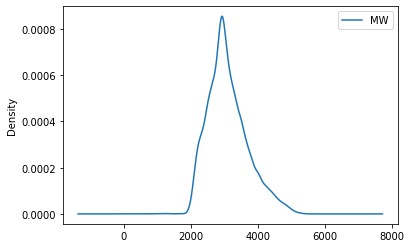

In [16]:
df.plot(kind='kde')

## Me aseguro que no queden Null

In [17]:
x=df[df["MW"].isnull()]
x

,MW
Datetime,


## Gráfico de los valores, no se vé tendencia, si aparece un componente estacional

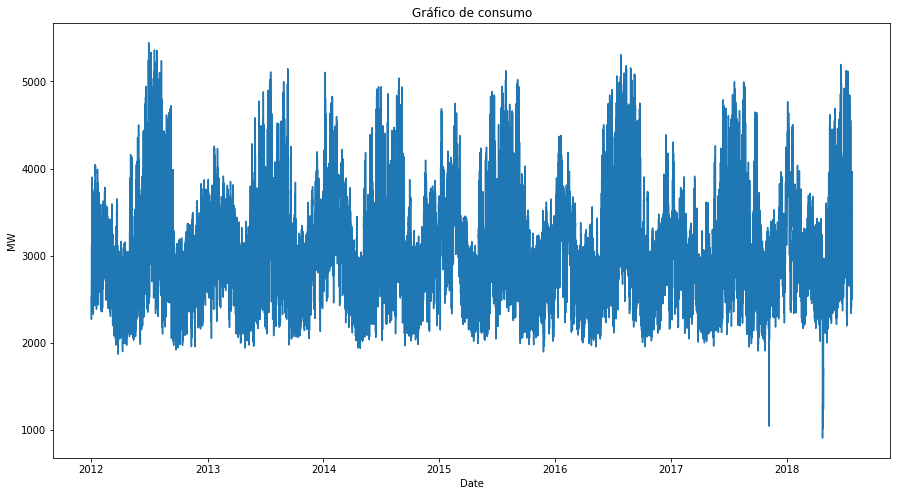

In [86]:
plt.figure(figsize=(15,8))
plt.xlabel("Date")
plt.ylabel("MW")
plt.title("Gráfico de consumo")
plt.plot(df)

## Se confirma que no hay tendencia y Hay un componente estacional

<Figure size 1152x2880 with 0 Axes>

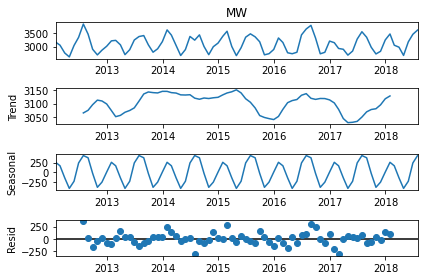

In [19]:
y = df['MW'].resample('1M').mean()


import statsmodels.api as sm
plt.figure(figsize=(16,40))
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

## Verifico que el P-vaue es menor que 0,5 con lo cual es estacionaria adicionalmente, no se detecta tendencia en la varianza. Sigue pareciendo estacional.

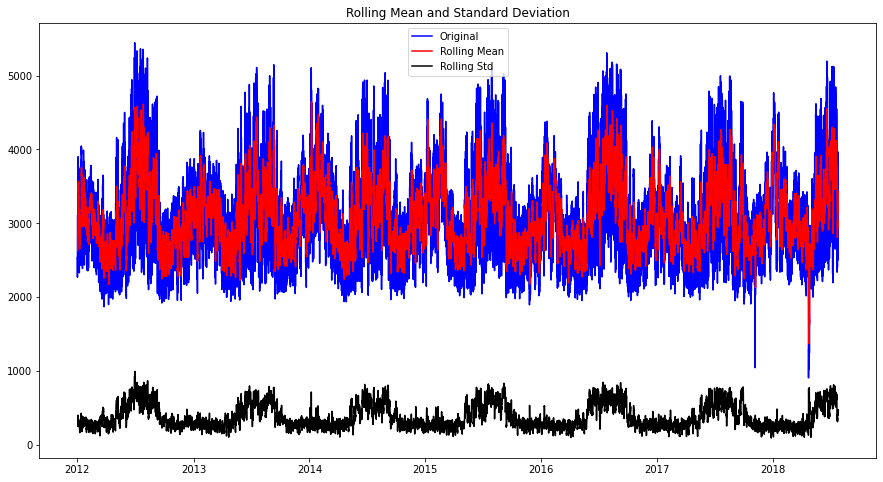

Results of dickey fuller test
Test Statistics               -1.475534e+01
p-value                        2.448854e-27
No. of lags used               5.800000e+01
Number of observations used    5.745900e+04
critical value (1%)           -3.430464e+00
critical value (5%)           -2.861590e+00
critical value (10%)          -2.566797e+00
dtype: float64


In [88]:

test_stationarity(df)

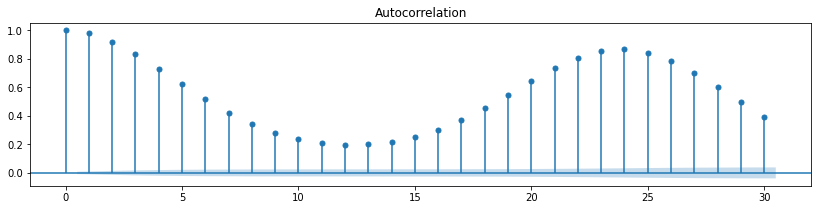

In [21]:
# Autocorrelation plot de la variable, muchos puntos con alta autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(14, 3))
plot_acf(df.MW, ax=ax, lags=30)
plt.show()

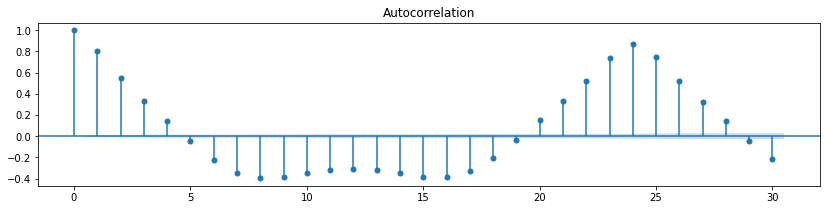

In [82]:
# Autocorrelation plot de la primer diferencía, mejoró 
# ==============================================================================
df_diff=df.diff().dropna()
fig, ax = plt.subplots(figsize=(14, 3))
plot_acf(df_diff.MW, ax=ax, lags=30)
plt.show()

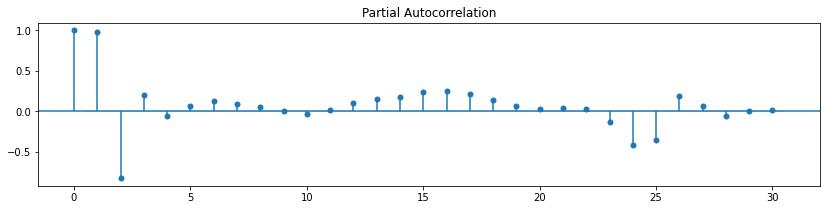

In [23]:
# Autocorrelación Parcial, vemos similar tendencia que en la autocorrelación.
# ==============================================================================

fig, ax = plt.subplots(figsize=(14, 3))
plot_pacf(df.MW, ax=ax, lags=30)
plt.show()

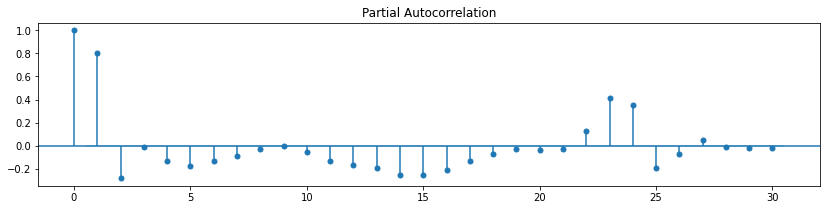

In [24]:
# Partial autocorrelation plot de la diferencia
# ==============================================================================

fig, ax = plt.subplots(figsize=(14, 3))
plot_pacf(df_diff.MW, ax=ax, lags=30)
plt.show()

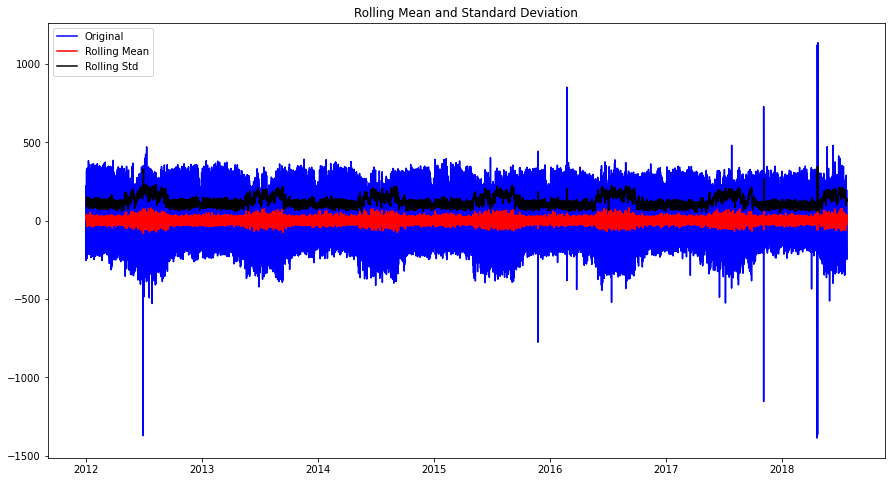

Results of dickey fuller test
Test Statistics                  -37.354321
p-value                            0.000000
No. of lags used                  59.000000
Number of observations used    57457.000000
critical value (1%)               -3.430464
critical value (5%)               -2.861590
critical value (10%)              -2.566797
dtype: float64


In [89]:
#Pruebo Dick folley de la diferencia, da mejor
# ==============================================================================
test_stationarity(df_diff)

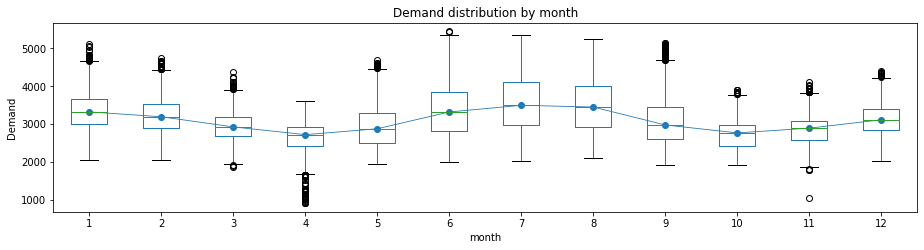

In [26]:
# Boxplot estacionalidad anual
# ==============================================================================
#Impresiona un mayor consumo en julio  y enero, probalemente debido a invierno y verano.

fig, ax = plt.subplots(figsize=(15, 3.5))
df['month'] = df.index.month
df.boxplot(column='MW', by='month', ax=ax,)
df.groupby('month')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by month')
fig.suptitle('');

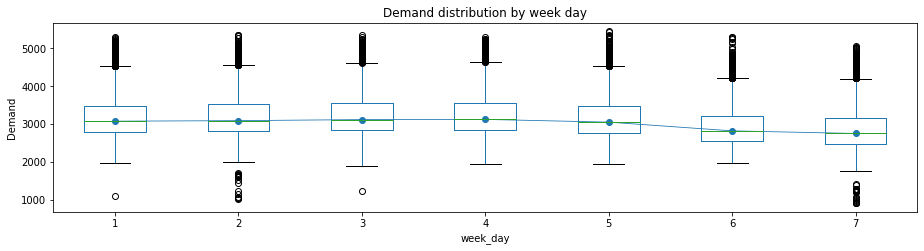

In [27]:
# Boxplot estacionalidad semanal.
# ==============================================================================
#Bastante parejo para todos los días cae, levemente sábado y domingo.

fig, ax = plt.subplots(figsize=(15, 3.5))
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='MW', by='week_day', ax=ax)
df.groupby('week_day')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by week day')
fig.suptitle('');

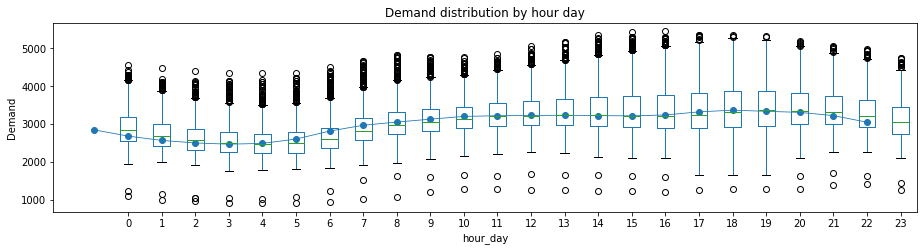

In [28]:
# Boxplot estacionalidad por hora.
# ==============================================================================
#Se percibe un aumento de consumo entre el mediodia y las 20hs.

fig, ax = plt.subplots(figsize=(15, 3.5))
df['hour_day'] = df.index.hour
df.boxplot(column='MW', by='hour_day', ax=ax)
df.groupby('hour_day')['MW'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Demand distribution by hour day')
fig.suptitle('');

### Modelo baseline Media 

In [29]:
df_train, df_test = train_test_split(df, test_size=8760, random_state=42, shuffle=False)
df_test["Mean_est"]=df_train["MW"].mean()

In [30]:
df_test

,MW,month,week_day,hour_day,Mean_est
Datetime,,,,,
2017-07-24 23:00:00,3726,7,1,23,3099.566799
2017-07-25 00:00:00,3384,7,2,0,3099.566799
2017-07-25 01:00:00,3096,7,2,1,3099.566799
2017-07-25 02:00:00,2852,7,2,2,3099.566799
2017-07-25 03:00:00,2696,7,2,3,3099.566799
...,...,...,...,...,...
2018-07-24 19:00:00,3954,7,2,19,3099.566799
2018-07-24 20:00:00,3851,7,2,20,3099.566799
2018-07-24 21:00:00,3766,7,2,21,3099.566799


In [31]:
evalu=evaluation(df_test['Mean_est'], df_test['MW'],verbose=0)

### Armo una tabla para comparar resultado de modelos

In [32]:
df_Results=pd.DataFrame()
df_Results.loc[1, "Model"] = "Media"
df_Results.loc[1, "RMSE"] = evalu[0]
df_Results.loc[1, "MAE"] = evalu[1]
df_Results.loc[1, "MAPE"] = evalu[2]

df_Results

,Model,RMSE,MAE,MAPE
1,Media,474.207,609.184,0.153


## Modelo LSTMs

In [34]:
df=df.iloc[:,0:1]

In [35]:
df.tail(30)

,MW
Datetime,
2018-07-23 18:00:00,3748
2018-07-23 19:00:00,3741
2018-07-23 20:00:00,3690
2018-07-23 21:00:00,3592
2018-07-23 22:00:00,3593
2018-07-23 23:00:00,3385
2018-07-24 00:00:00,3152
2018-07-24 01:00:00,2904
2018-07-24 02:00:00,2745


In [36]:
from sklearn.preprocessing import MinMaxScaler
import math
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

In [37]:
# fix random seed for reproducibility
np.random.seed(7)

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)

In [39]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

38537 18981


In [40]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [41]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [42]:
trainY

array([0.34332305, 0.32106655, 0.30982812, ..., 0.53657999, 0.53613927,
       0.47796386])

In [43]:

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [45]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

model.summary()
model.compile(loss='mean_squared_error', optimizer='adamax')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 4)                 96        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
38535/38535 - 32s - loss: 0.0036 - 32s/epoch - 832us/step
Epoch 2/10
38535/38535 - 32s - loss: 7.9125e-04 - 32s/epoch - 842us/step
Epoch 3/10
38535/38535 - 32s - loss: 7.8957e-04 - 32s/epoch - 822us/step
Epoch 4/10
38535/38535 - 32s - loss: 7.8991e-04 - 32s/epoch - 823us/step
Epoch 5/10
38535/38535 - 31s - loss: 7.9042e-04 - 31s/epoch - 811us/step
Epoch 6/10
38535/38535 - 32s - loss: 7.9107e-04 - 32s/epoch - 826us/step
Epoch 7/10
38535/3

In [ ]:
len(trainY)

In [46]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
#trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
#print('Train Score: %.2f RMSE' % (trainScore))
#testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
#print('Test Score: %.2f RMSE' % (testScore))

In [48]:
evalu=evaluation(testPredict[:,0], testY[0] ,verbose=0)

### En la tabla de abajo, mostrando los errores se ve claramente que el LSTM es nucho mejor de la media. Por ejemplo RSME 107 para LSTM y 474 para la media.

In [49]:
#Este modelo funciona mucho mejor que la media y que el ARIMA y la regre (de la R1)

df_Results.loc[3, "Model"] = "LSTM"
df_Results.loc[3, "RMSE"] = evalu[0]
df_Results.loc[3, "MAE"] = evalu[1]
df_Results.loc[3, "MAPE"] = evalu[2]

df_Results

,Model,RMSE,MAE,MAPE
1,Media,474.207,609.184,0.153
3,LSTM,107.121,134.534,0.034


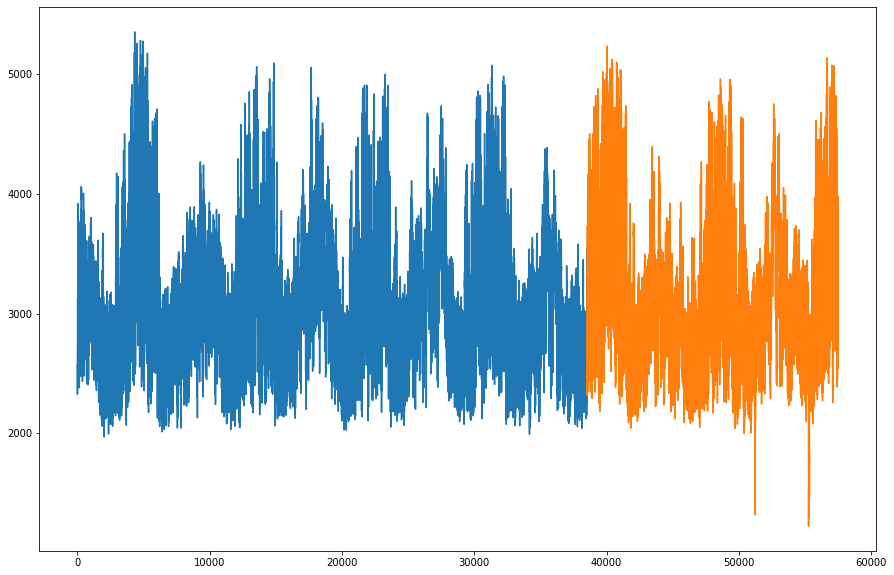

In [85]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(15, 10))
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [53]:
df=df.iloc[:,0:1]
df

,MW
Datetime,
2012-01-01 01:00:00,2533
2012-01-01 02:00:00,2465
2012-01-01 03:00:00,2364
2012-01-01 04:00:00,2313
2012-01-01 05:00:00,2279
...,...
2018-07-24 19:00:00,3954
2018-07-24 20:00:00,3851
2018-07-24 21:00:00,3766


## Forecast con LSTMs

In [54]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df)
y = scaler.transform(df)

# generate the input and output sequences
n_lookback = 1  # length of input sequences (lookback period)
n_forecast = 192  # length of output sequences (forecast period)
y.shape

(57518, 1)

In [55]:
X = []
Y = []

for i in range(n_lookback, len(y) - n_forecast + 1):
    X.append(y[i - n_lookback: i])
    Y.append(y[i: i + n_forecast])

X = np.array(X)
Y = np.array(Y)
Y.shape

(57326, 192, 1)

In [56]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(n_lookback, 1)))
model.add(LSTM(units=50))
model.add(Dense(n_forecast))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=10, batch_size=32, verbose=2)


Epoch 1/10
1792/1792 - 5s - loss: 0.0212 - 5s/epoch - 3ms/step
Epoch 2/10
1792/1792 - 3s - loss: 0.0144 - 3s/epoch - 2ms/step
Epoch 3/10
1792/1792 - 3s - loss: 0.0144 - 3s/epoch - 2ms/step
Epoch 4/10
1792/1792 - 3s - loss: 0.0144 - 3s/epoch - 2ms/step
Epoch 5/10
1792/1792 - 3s - loss: 0.0144 - 3s/epoch - 2ms/step
Epoch 6/10
1792/1792 - 3s - loss: 0.0144 - 3s/epoch - 2ms/step
Epoch 7/10
1792/1792 - 3s - loss: 0.0144 - 3s/epoch - 2ms/step
Epoch 8/10
1792/1792 - 3s - loss: 0.0143 - 3s/epoch - 2ms/step
Epoch 9/10
1792/1792 - 4s - loss: 0.0144 - 4s/epoch - 2ms/step
Epoch 10/10
1792/1792 - 4s - loss: 0.0143 - 4s/epoch - 2ms/step


In [57]:
X_ = y[- n_lookback:]  # last available input sequence
X_ = X_.reshape(1, n_lookback, 1)

Y_ = model.predict(X_).reshape(-1, 1)
Y_ = scaler.inverse_transform(Y_)

In [58]:
df_past = df[['MW']].reset_index()

df_past.rename(columns={'index': 'Datetime', 'MW': 'Actual'}, inplace=True)
df_past['Datetime'] = pd.to_datetime(df_past['Datetime'])
df_past['Forecast'] = np.nan
df_past['Forecast'].iloc[-1] = df_past['Actual'].iloc[-1]

In [59]:
df_past

,Datetime,Actual,Forecast
0,2012-01-01 01:00:00,2533,NaN
1,2012-01-01 02:00:00,2465,NaN
2,2012-01-01 03:00:00,2364,NaN
3,2012-01-01 04:00:00,2313,NaN
4,2012-01-01 05:00:00,2279,NaN
...,...,...,...
57513,2018-07-24 19:00:00,3954,NaN
57514,2018-07-24 20:00:00,3851,NaN
57515,2018-07-24 21:00:00,3766,NaN
57516,2018-07-24 22:00:00,3720,NaN


In [60]:
#Predicciones de consumo
df_future = pd.DataFrame(columns=['Datetime', 'Actual', 'Forecast'])
df_future['Datetime'] = pd.date_range(start=df_past['Datetime'].iloc[-1] + pd.Timedelta(hours=1), periods=n_forecast,freq='60min')
df_future['Forecast'] = Y_.flatten()
df_future['Actual'] = np.nan


In [61]:
print(df_future.tail(39))

               Datetime  Actual     Forecast
153 2018-07-31 09:00:00     NaN  3143.375732
154 2018-07-31 10:00:00     NaN  3118.631592
155 2018-07-31 11:00:00     NaN  3099.417236
156 2018-07-31 12:00:00     NaN  3085.486084
157 2018-07-31 13:00:00     NaN  3079.313965
158 2018-07-31 14:00:00     NaN  3088.142090
159 2018-07-31 15:00:00     NaN  3103.880615
160 2018-07-31 16:00:00     NaN  3137.616211
161 2018-07-31 17:00:00     NaN  3180.157959
162 2018-07-31 18:00:00     NaN  3226.793457
163 2018-07-31 19:00:00     NaN  3271.498291
164 2018-07-31 20:00:00     NaN  3315.958008
165 2018-07-31 21:00:00     NaN  3359.122314
166 2018-07-31 22:00:00     NaN  3390.867432
167 2018-07-31 23:00:00     NaN  3400.989502
168 2018-08-01 00:00:00     NaN  3394.006592
169 2018-08-01 01:00:00     NaN  3363.624756
170 2018-08-01 02:00:00     NaN  3333.750732
171 2018-08-01 03:00:00     NaN  3298.964600
172 2018-08-01 04:00:00     NaN  3269.694580
173 2018-08-01 05:00:00     NaN  3234.126221
174 2018-0

In [62]:
results = df_past[57000:].append(df_future).set_index('Datetime')

<AxesSubplot:title={'center':'Prediction'}, xlabel='Datetime'>

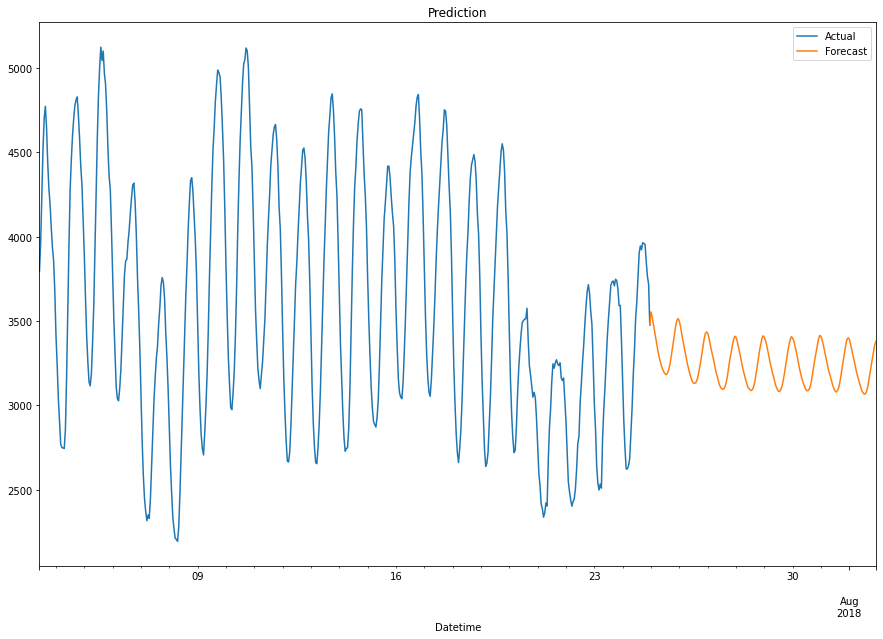

In [84]:
#Gráfico de consumo pasado y el forecast
fig, ax = plt.subplots(figsize=(15, 10))
results.plot(title='Prediction',ax=ax)

In [64]:
df_future=df_future.drop(columns=["Actual"])

In [65]:
df_future.rename(columns={"Forecast": "Prediction"},inplace=True)

In [79]:
df_future.Prediction=df_future.Prediction.round()

In [80]:
df_future.to_csv('../Data/Forecast_Energy_Load_192h.csv')   

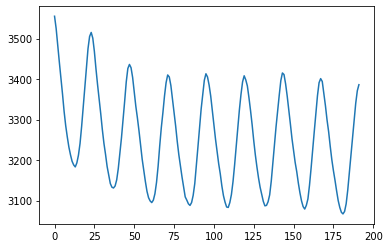

In [81]:


plt.plot( df_future['Prediction'] )
plt.show()